In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

def rossler_rhs(xyz, a=0.2, b=0.2, c=5.7):
    x, y, z = xyz
    return np.array([-y - z, x + a * y, b + z * (x - c)], dtype=np.float64)

def simulate_rossler_rk4(dt=0.01, num_steps=200000, y0=(1.0, 1.0, 0.0), burn=2000, a=0.2, b=0.2, c=5.7):
    Y = np.zeros((num_steps + 1, 3), dtype=np.float64)
    Y[0] = np.array(y0, dtype=np.float64)
    for i in range(num_steps):
        y = Y[i]
        k1 = rossler_rhs(y, a=a, b=b, c=c)
        k2 = rossler_rhs(y + 0.5 * dt * k1, a=a, b=b, c=c)
        k3 = rossler_rhs(y + 0.5 * dt * k2, a=a, b=b, c=c)
        k4 = rossler_rhs(y + dt * k3, a=a, b=b, c=c)
        Y[i + 1] = y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return Y[burn:]

def delay_embed_scalar(obs, m, tau):
    obs = np.asarray(obs, dtype=np.float64)
    L = obs.shape[0] - (m - 1) * tau
    if L <= 1:
        raise ValueError(f"Too short for delay embedding: len(obs)={len(obs)}, m={m}, tau={tau}")
    Z = np.empty((L, m), dtype=np.float64)
    for j in range(m):
        Z[:, j] = obs[(m - 1 - j) * tau : (m - 1 - j) * tau + L]
    return Z

def fit_lift(X, poly_deg=3):
    poly = PolynomialFeatures(degree=poly_deg, include_bias=False)
    Phi_raw = poly.fit_transform(X)
    scaler = StandardScaler(with_mean=True, with_std=True)
    Phi = scaler.fit_transform(Phi_raw)
    return poly, scaler, Phi

def lift_transform(X, poly, scaler):
    return scaler.transform(poly.transform(X))

def ridge_solve(PhiX, PhiY, alpha):
    G = PhiX.T @ PhiX
    A = G + alpha * np.eye(G.shape[0], dtype=np.float64)
    K = np.linalg.solve(A, PhiX.T @ PhiY)
    return K

def ridge_decode(Phi, Y, beta):
    G = Phi.T @ Phi
    A = G + beta * np.eye(G.shape[0], dtype=np.float64)
    B = np.linalg.solve(A, Phi.T @ Y)
    return B

def edmd_rollout_metrics_3d(
    Y_train,
    Y_test,
    obs_idx,
    m,
    tau,
    horizons,
    poly_deg=3,
    alpha_K=1e-6,
    beta_B=1e-6,
    train_frac=0.7,
    eval_stride=5,
):
    horizons = sorted(list(horizons))
    Hmax = max(horizons)

    Ztr = delay_embed_scalar(Y_train[:, obs_idx], m=m, tau=tau)
    Ltr = Ztr.shape[0]
    Ytr_align = Y_train[(m - 1) * tau : (m - 1) * tau + Ltr]

    tr_end = int(train_frac * Ltr)
    tr_end = max(tr_end, 2)

    X_snap = Ztr[:tr_end - 1]
    Y_snap = Ztr[1:tr_end]

    poly, scaler, PhiX = fit_lift(X_snap, poly_deg=poly_deg)
    PhiY = lift_transform(Y_snap, poly, scaler)

    K = ridge_solve(PhiX, PhiY, alpha=alpha_K)

    S_snap = Ytr_align[:tr_end - 1]
    B = ridge_decode(PhiX, S_snap, beta=beta_B)

    var_train = S_snap.var(axis=0)
    sigma_3d = float(np.sqrt(var_train.sum()))
    if sigma_3d == 0:
        sigma_3d = 1.0

    Zte = delay_embed_scalar(Y_test[:, obs_idx], m=m, tau=tau)
    Lte = Zte.shape[0]
    Yte_align = Y_test[(m - 1) * tau : (m - 1) * tau + Lte]
    Phi0_all = lift_transform(Zte, poly, scaler)

    out = {}
    for n in horizons:
        N0 = Lte - n
        idx = np.arange(0, N0, eval_stride, dtype=int)
        Phi0 = Phi0_all[idx]

        Kn = np.linalg.matrix_power(K, n)
        Phin = Phi0 @ Kn
        That = Phin @ B

        Tte = Yte_align[n:][idx]
        err = That - Tte

        mse_3d = float(np.mean(np.sum(err ** 2, axis=1)))
        nrmse_3d = float(np.sqrt(mse_3d) / sigma_3d)

        out[n] = {"mse_3d": mse_3d, "nrmse_3d": nrmse_3d}

    return out

dt = 0.01
num_steps = 20000
burn = 2000

Y_train = simulate_rossler_rk4(dt=dt, num_steps=num_steps, y0=(1.0, 1.0, 0.0), burn=burn)
Y_test  = simulate_rossler_rk4(dt=dt, num_steps=num_steps, y0=(1.2, 0.8, 0.2), burn=burn)

horizons = [100, 200, 300, 400, 500, 600, 700, 800]
poly_deg = 3
alpha_K = 1e-6
beta_B = 1e-6
train_frac = 0.7
eval_stride = 5

m_list = [3, 5, 7]
tau_list = [50, 100]

rows = []
for m in m_list:
    for tau in tau_list:
        res_x = edmd_rollout_metrics_3d(
            Y_train, Y_test, obs_idx=0, m=m, tau=tau, horizons=horizons,
            poly_deg=poly_deg, alpha_K=alpha_K, beta_B=beta_B,
            train_frac=train_frac, eval_stride=eval_stride
        )
        res_z = edmd_rollout_metrics_3d(
            Y_train, Y_test, obs_idx=2, m=m, tau=tau, horizons=horizons,
            poly_deg=poly_deg, alpha_K=alpha_K, beta_B=beta_B,
            train_frac=train_frac, eval_stride=eval_stride
        )
        for n in horizons:
            if n in res_x:
                rx = res_x[n]
                rows.append(("x time-delay", m, tau, n, rx["mse_3d"], rx["nrmse_3d"]))
            if n in res_z:
                rz = res_z[n]
                rows.append(("z time-delay", m, tau, n, rz["mse_3d"], rz["nrmse_3d"]))

df = pd.DataFrame(rows, columns=["observable", "m", "tau", "horizon", "MSE_3D", "NRMSE_3D"])
df = df.sort_values(["m", "tau", "horizon", "observable"]).reset_index(drop=True)

print(df.to_string(index=False))
df.to_csv("edmd_rollout_3d_metrics_grid.csv", index=False)
print("\nSaved: edmd_rollout_3d_metrics_grid.csv")

  observable  m  tau  horizon    MSE_3D  NRMSE_3D
x time-delay  3   50      100  5.105167  0.298374
z time-delay  3   50      100 68.243469  1.090903
x time-delay  3   50      200  6.332623  0.332313
z time-delay  3   50      200 65.320971  1.067289
x time-delay  3   50      300  7.268031  0.356012
z time-delay  3   50      300 62.544636  1.044361
x time-delay  3   50      400  7.953481  0.372421
z time-delay  3   50      400 67.251177  1.082943
x time-delay  3   50      500 12.777171  0.472034
z time-delay  3   50      500 65.812066  1.071293
x time-delay  3   50      600 21.174219  0.607658
z time-delay  3   50      600 59.569915  1.019223
x time-delay  3   50      700 31.946782  0.746396
z time-delay  3   50      700 61.335520  1.034217
x time-delay  3   50      800 36.402863  0.796753
z time-delay  3   50      800 56.799399  0.995239
x time-delay  3  100      100  6.802853  0.345161
z time-delay  3  100      100 56.734731  0.996784
x time-delay  3  100      200  8.973239  0.396416


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from numba import jit
import warnings
@jit(nopython=True, fastmath=True)
def compute_errors_numba(neighbor_clouds, max_iter=50, eps=1e-5):
    n_samples, k, dim = neighbor_clouds.shape
    errors = np.empty(n_samples, dtype=np.float64)
    
    for i in range(n_samples):
        cloud = neighbor_clouds[i]
        
        y = np.zeros(dim)
        for d in range(dim):
            sum_val = 0.0
            for j in range(k):
                sum_val += cloud[j, d]
            y[d] = sum_val / k
            
        for _ in range(max_iter):
            sum_weights = 0.0
            y_next = np.zeros(dim)
            distances = np.empty(k)
            all_non_zero = True
            
            for j in range(k):
                dist_sq = 0.0
                for d in range(dim):
                    diff = cloud[j, d] - y[d]
                    dist_sq += diff * diff
                dist = np.sqrt(dist_sq)
                distances[j] = dist
                
                if dist < 1e-10: 
                    all_non_zero = False
                    for d in range(dim): y[d] = cloud[j, d]
                    break
                
                w = 1.0 / dist
                sum_weights += w
                for d in range(dim):
                    y_next[d] += cloud[j, d] * w
            
            if not all_non_zero: break 
            
            diff_norm_sq = 0.0
            for d in range(dim):
                y_next[d] /= sum_weights
                diff = y[d] - y_next[d]
                diff_norm_sq += diff * diff
                y[d] = y_next[d]
                
            if np.sqrt(diff_norm_sq) < eps:
                break
        
        total_dist = 0.0
        for j in range(k):
            dist_sq = 0.0
            for d in range(dim):
                diff = cloud[j, d] - y[d]
                dist_sq += diff * diff
            total_dist += np.sqrt(dist_sq)
            
        errors[i] = total_dist / k
        
    return errors

def check_embedding_condition(data, threshold=1e10):
    data_centered = data - np.mean(data, axis=0)
    s = np.linalg.svdvals(data_centered)
    if s[-1] < 1e-12:
        return np.inf
    return s[0] / s[-1]

def power_law_model(k, intercept, coef, gamma):
    return intercept + coef * (k ** gamma)

# Estimate intrinsic stochasticity at fixed k
import numpy as np
import warnings
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors

def estimate_intrinsic_stochasticity(
    embedding_data,
    pushforward,
    k=50,
    n_samples=5000,
    cond_threshold=1000,
    random_state=0,
    return_pointwise=False,
    theiler_w=0,          
    buffer_mult=6,        
    pre_scaled=False,     
    strict_theiler=True,  
):
    if k <= 1:
        raise ValueError("k must be >= 2.")
    if pushforward <= 0:
        raise ValueError("pushforward must be >= 1.")
    if theiler_w < 0:
        raise ValueError("theiler_w must be >= 0.")
    if buffer_mult < 1:
        raise ValueError("buffer_mult must be >= 1.")

    if pre_scaled:
        data_norm = np.asarray(embedding_data)
    else:
        scaler = RobustScaler()
        data_norm = scaler.fit_transform(np.asarray(embedding_data))

    cond_num = check_embedding_condition(data_norm)
    if (cond_num > cond_threshold) or np.isinf(cond_num):
        warnings.warn(
            f"CRITICAL WARNING: Rank Deficient! Condition Number = {cond_num:.2e}. Skipping."
        )
        return None

    T = data_norm.shape[0]
    max_start = T - pushforward
    if max_start <= 0:
        raise ValueError("Pushforward too large for the given data length.")

    X_curr = data_norm[:max_start]
    Y_fut  = data_norm[pushforward:]

    rng = np.random.default_rng(random_state)
    n_q = int(min(n_samples, max_start))
    query_idx = rng.choice(max_start, size=n_q, replace=False)

    k_query = int(min(max_start, max(k * buffer_mult, k + 2 * theiler_w + 5)))
    nbrs = NearestNeighbors(n_neighbors=k_query, algorithm="auto", n_jobs=-1).fit(X_curr)

    dist_raw, idx_raw = nbrs.kneighbors(X_curr[query_idx]) 

    nn_idx = np.empty((n_q, k), dtype=np.int64)
    rk = np.empty(n_q, dtype=np.float64)  

    not_enough = 0

    for r in range(n_q):
        q = int(query_idx[r])
        cand = idx_raw[r]
        cand_d = dist_raw[r]

        picked = 0
        last_d = 0.0

        for j in range(k_query):
            t = int(cand[j])
            if t == q:
                continue
            if theiler_w > 0 and (abs(t - q) <= theiler_w):
                continue
            nn_idx[r, picked] = t
            last_d = float(cand_d[j])  
            picked += 1
            if picked == k:
                break

        if picked < k:
            not_enough += 1
            if strict_theiler:
                raise RuntimeError(
                    f"Not enough valid neighbors after exclusion"
                )
            else:
                picked2 = 0
                last_d = 0.0
                for j in range(k_query):
                    t = int(cand[j])
                    if t == q:
                        continue
                    nn_idx[r, picked2] = t
                    last_d = float(cand_d[j])
                    picked2 += 1
                    if picked2 == k:
                        break

        rk[r] = last_d

    neighbor_clouds = Y_fut[nn_idx] 

    local_errors = compute_errors_numba(neighbor_clouds)
    E_star_k = float(np.mean(local_errors))

    out = {
        "E_star_k": E_star_k,
        "k": int(k),
        "pushforward": int(pushforward),
        "theiler_w": int(theiler_w),
        "n_queries": int(n_q),
        "condition_number": float(cond_num),
        "not_enough_queries": int(not_enough),
        "strict_theiler": bool(strict_theiler),
        "median_rk": float(np.median(rk)),
        "q90_rk": float(np.quantile(rk, 0.90)),
        "mean_rk": float(np.mean(rk)),
    }
    if return_pointwise:
        out["pointwise_errors"] = local_errors
        out["query_idx"] = query_idx
        out["nn_idx"] = nn_idx
        out["rk"] = rk
    return out

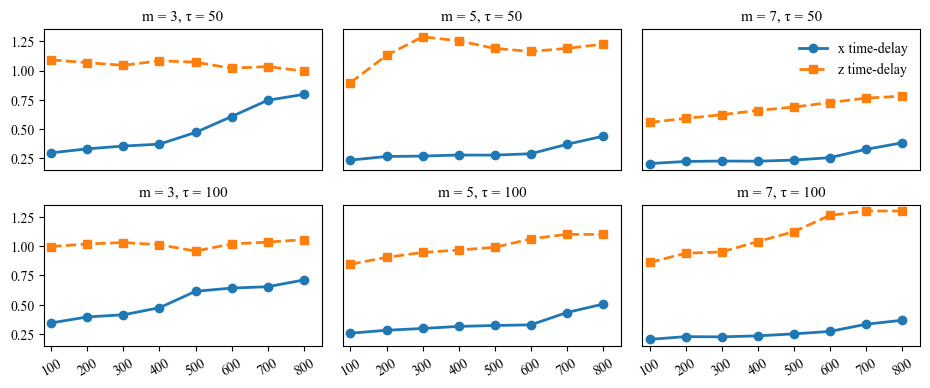

In [96]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

def plot_edmd_metric_grid_2x3(df, horizons, y_col="NRMSE_all"):
    m_vals = [3, 5, 7]
    tau_vals = [50, 100]

    fig, axes = plt.subplots(2, 3, figsize=(10.0, 4.8), sharex=True, sharey=True)

    x_min, x_max = 80, 850

    horizons_in_df = sorted(set(df["horizon"].astype(int).tolist()))
    xticks = [h for h in horizons_in_df if 80 < h < 850]

    for i, tau_val in enumerate(tau_vals):
        for j, m_val in enumerate(m_vals):
            ax = axes[i, j]

            group = df[(df["m"] == m_val) & (df["tau"] == tau_val)]

            g_x = group[group["observable"] == "x time-delay"].sort_values("horizon")
            g_z = group[group["observable"] == "z time-delay"].sort_values("horizon")

            Hx = g_x["horizon"].to_numpy()
            Hz = g_z["horizon"].to_numpy()

            y_x = g_x[y_col].to_numpy()
            y_z = g_z[y_col].to_numpy()

            ax.plot(Hx, y_x, marker="o", lw=2.0, linestyle="-", label="x time-delay")
            ax.plot(Hz, y_z, marker="s", lw=2.0, linestyle="--", label="z time-delay")

            ax.set_title(f"m = {m_val}, τ = {tau_val}", fontsize=11)
            ax.grid(False)
            ax.set_xlim(x_min, x_max)
            ax.tick_params(top=False, right=False)

            if i == 0:
                ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
            if j != 0:
                ax.tick_params(axis="y", which="both", left=False, labelleft=False)

            if i == 0 and j == 2:
                ax.legend(loc="upper right", frameon=False, fontsize=10)

    for ax in axes[1, :]:
        ax.set_xticks(xticks)
        ax.set_xticklabels([str(h) for h in xticks], rotation=30)

    fig.tight_layout(rect=[0.06, 0.12, 1, 0.95])
    #plt.savefig(f"edmd_{y_col}_grid_2x3.pdf", dpi=300)
    plt.savefig(f"edmd_{y_col}_grid_2x3.png", dpi=600)
    plt.show()

plot_edmd_metric_grid_2x3(df, horizons=[80, 100, 200, 300, 400, 500, 600, 700, 800, 850], y_col="NRMSE_3D")

In [6]:
Ztr = delay_embed_scalar(Y_train[:, 0], m=3, tau=100)
print(estimate_intrinsic_stochasticity(
                embedding_data=Ztr,
                pushforward=20,
                k=50,
                n_samples=5000,
                cond_threshold=1000,
                theiler_w=30,
                buffer_mult=6,
                pre_scaled=False,
                strict_theiler=True,
            )['E_star_k'])
Ztr1 = delay_embed_scalar(Y_train[:, 2], m=3, tau=100)
print(estimate_intrinsic_stochasticity(
                embedding_data=Ztr1,
                pushforward=20,
                k=50,
                n_samples=5000,
                cond_threshold=1000,
                theiler_w=30,
                buffer_mult=6,
                pre_scaled=False,
                strict_theiler=True,
            )['E_star_k'])

0.057721057499525504
5.077146654100282


(np.float64(-10.572509042015039),
 np.float64(12.901054470451028),
 np.float64(-12.113327192626533),
 np.float64(9.171324152204011),
 np.float64(-0.45694082540171244),
 np.float64(23.067709993498877))

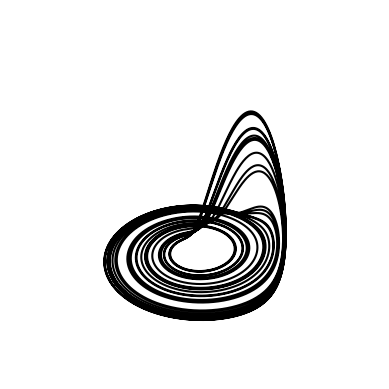

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=Y_train[:,0], ys=Y_train[:,1], zs=Y_train[:,2], color='k')
plt.axis('off')

(np.float64(-900.0),
 np.float64(18900.0),
 np.float64(-10.103037771765717),
 np.float64(12.431583200201706))

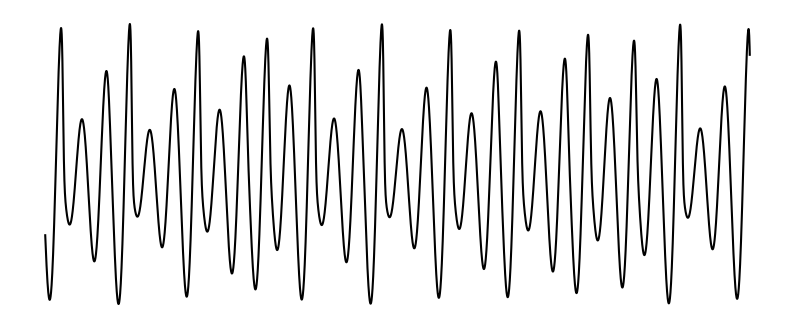

In [66]:
plt.figure(figsize=(10,4))
plt.plot(Y_train[:,0],'k')
plt.xticks([])
plt.yticks([])
plt.axis('off')

(np.float64(-900.0),
 np.float64(18900.0),
 np.float64(-1.115631048330929),
 np.float64(23.726400216428093))

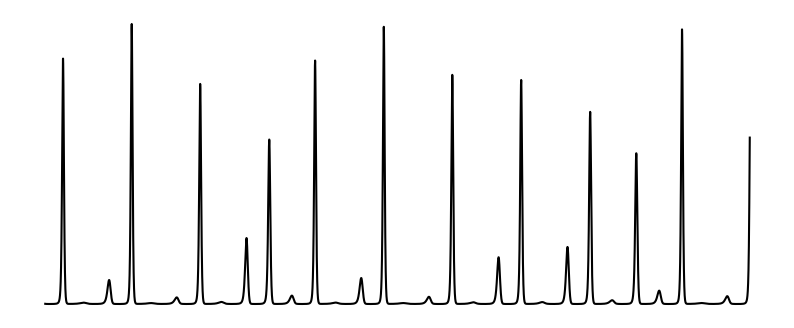

In [67]:
plt.figure(figsize=(10,4))
plt.plot(Y_train[:,2],'k')
plt.xticks([])
plt.yticks([])
plt.axis('off')

(np.float64(-10.572509042015039),
 np.float64(12.901054470451028),
 np.float64(-10.572509042015039),
 np.float64(12.901054470451028),
 np.float64(-9.505528882357488),
 np.float64(11.834074310793477))

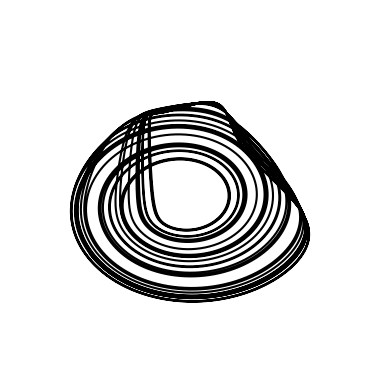

In [68]:
Ztr = delay_embed_scalar(Y_train[:, 0], m=3, tau=100)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=Ztr[:,0], ys=Ztr[:,1], zs=Ztr[:,2], color='k')
plt.axis('off')

(np.float64(-1.633173366346742),
 np.float64(24.243942534443907),
 np.float64(-1.633173366346742),
 np.float64(24.243942534443907),
 np.float64(-0.45694082540171244),
 np.float64(23.067709993498877))

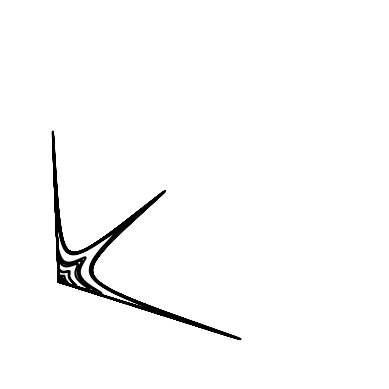

In [69]:
Ztr = delay_embed_scalar(Y_train[:, 2], m=3, tau=100)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=Ztr[:,0], ys=Ztr[:,1], zs=Ztr[:,2], color='k')
plt.axis('off')

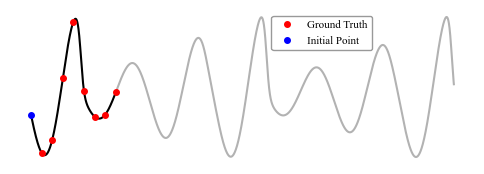

In [123]:
plt.figure(figsize=(6, 2))
plt.plot(np.arange(800), Y_test[:800, 0], 'k')
plt.plot(np.arange(800, 4000), Y_test[800:4000, 0], color='gray', alpha=0.6)
dot_indices = np.arange(100, 900, 100) 
plt.plot(dot_indices, Y_test[dot_indices, 0], 'r.', markersize=8, label = 'Ground Truth')
plt.plot(0, Y_test[0, 0], 'b.', markersize=8, label = 'Initial Point')
plt.xticks([])
plt.yticks([])
leg = plt.legend(frameon=True, loc='upper right', bbox_to_anchor=(0.79, 1.0), fontsize=8)
leg.get_frame().set_edgecolor('gray')
plt.axis('off')
plt.savefig("downstream_edmd_x_observable.png", dpi=300)
plt.show()

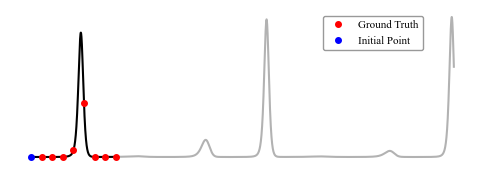

In [128]:
plt.figure(figsize=(6, 2))
plt.plot(np.arange(800), Y_test[:800, 2], 'k')
plt.plot(np.arange(800, 4000), Y_test[800:4000, 2], color='gray', alpha=0.6)
dot_indices = np.arange(100, 900, 100) 
plt.plot(dot_indices, Y_test[dot_indices, 2], 'r.', markersize=8, label = 'Ground Truth')
plt.plot(0, Y_test[0, 2], 'b.', markersize=8, label = 'Initial Point')
leg = plt.legend(frameon=True, loc='upper right', bbox_to_anchor=(0.9, 1.0), fontsize=8)   
leg.get_frame().set_edgecolor('gray')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()